# Building a CNN for Hiragana character recognition using PyTorch

In [1]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torchvision.transforms import ToPILImage

## Building the model

In [2]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()
		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	# Defining the forward pass function. Implenting this function as a class method
	# is mandatory in PyTorch, because our LeNet class extends (inherits from) the Module super class.
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

The model is created as a class that extends (inherits from) the Module class, which is a fundamental building block for creating neural network models. It is a base class that provides a framework for defining and organizing the layers and operations of a neural network. However, using it requires the "daughter" class (LeNet) to have a forward pas function.
This is why the $\textit{forward}$ function is defined as a class method rather than a standalone function.

The network architecture is as follows: 
* Two successive blocks of Convolution -> ReLu -> MaxPool. Both Conv2D layers use 5x5 filters.
* Flatten
* One fully connected layer with ReLu as the activation function
* The last layer, fully connected as well, with Softmax the activation function.

## Training the model

In [3]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.lenet import LeNet
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

### Defining constants and hyperparameters

In [4]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Preparing the dataset

In [5]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())
# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading the KMNIST dataset...
[INFO] generating the train/validation split...


In [6]:
# initializing the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

### Creating a data loader for the training, validation and testing sets

This is to load the data in batches of pre-defined size and ensuring randomization (shuffling) of the data.

In [7]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


### Initializing the LeNet NN

In [8]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1, # The images are in grayscale, so the number of channels is 1
	classes=len(trainData.dataset.classes)).to(device) # We are using the local CPU because of some issues with working in colab
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()# Negative Log Likelihood Loss function, because the output of the model is expected to be a probability distribution over classes.
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

[INFO] initializing the LeNet model...
[INFO] training the network...


### Model training

In [9]:
# loop over our epochs
for e in range(EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
  # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

  ########################################################
    # calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))
# finish measuring how long training took
endTime = time.time()

[INFO] EPOCH: 1/10
Train loss: 0.364390, Train accuracy: 0.8864
Val loss: 0.136839, Val accuracy: 0.9583

[INFO] EPOCH: 2/10
Train loss: 0.097843, Train accuracy: 0.9702
Val loss: 0.092384, Val accuracy: 0.9729

[INFO] EPOCH: 3/10
Train loss: 0.058594, Train accuracy: 0.9814
Val loss: 0.087238, Val accuracy: 0.9733

[INFO] EPOCH: 4/10
Train loss: 0.038336, Train accuracy: 0.9882
Val loss: 0.077489, Val accuracy: 0.9775

[INFO] EPOCH: 5/10
Train loss: 0.024811, Train accuracy: 0.9920
Val loss: 0.077401, Val accuracy: 0.9796

[INFO] EPOCH: 6/10
Train loss: 0.019243, Train accuracy: 0.9936
Val loss: 0.085678, Val accuracy: 0.9785

[INFO] EPOCH: 7/10
Train loss: 0.016315, Train accuracy: 0.9948
Val loss: 0.103697, Val accuracy: 0.9746

[INFO] EPOCH: 8/10
Train loss: 0.012538, Train accuracy: 0.9959
Val loss: 0.078548, Val accuracy: 0.9810

[INFO] EPOCH: 9/10
Train loss: 0.009840, Train accuracy: 0.9970
Val loss: 0.086495, Val accuracy: 0.9801

[INFO] EPOCH: 10/10
Train loss: 0.012718, Trai

## Evaluating the model

In [10]:
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] total time taken to train the model: 366.66s
[INFO] evaluating network...
              precision    recall  f1-score   support

           o       0.97      0.94      0.96      1000
          ki       0.97      0.91      0.94      1000
          su       0.91      0.92      0.91      1000
         tsu       0.96      0.96      0.96      1000
          na       0.92      0.94      0.93      1000
          ha       0.94      0.95      0.95      1000
          ma       0.95      0.94      0.95      1000
          ya       0.96      0.97      0.97      1000
          re       0.92      0.98      0.95      1000
          wo       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



As we can see, the model performance is very good with respect to accuracy, recall, precision and f1 score. However, the training took 366.66 seconds (6 minutes) because we run it locally and without GPU.

## Plotting the training history

In [11]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
plt.savefig("plot.png") #Save
# serialize the model to disk
torch.save(model, "model.hpt")

The plot image was initially supposed to be stored locally and accessed though command line arguments (args["plot"]). But what we do here to make it work is to save the image in the current workspace and display it in a cell output using IPython (see cell below)

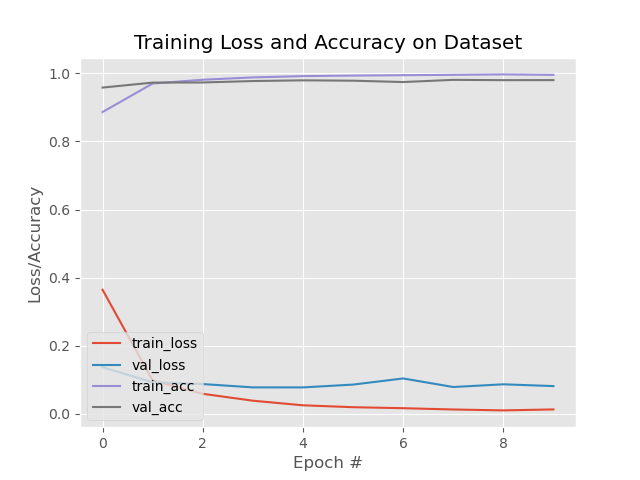

In [12]:
from PIL import Image
from IPython.display import display

# Opening the image file
image_path = 'plot.png'
image = Image.open(image_path)

# Displaying the image
display(image)

We can see that the training and validation accuracy gradually tend to 1 while the losses decrease to 0. As expected, the validation loss is higher than the training loss, while the inverse is true for the accuracy.

## Using the model to make predictions

In [13]:
# set the numpy seed for better reproducibility
import numpy as np
np.random.seed(42)
# import the necessary packages
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
import imutils
import torch
import cv2

In [14]:
# set the device we will be using to test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the KMNIST dataset and randomly grab 10 data points
print("[INFO] loading the KMNIST test dataset...")
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testData = Subset(testData, idxs)
# initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)
# load the model and set it to evaluation mode
Model = torch.load("model.hpt").to(device)
Model.eval()

[INFO] loading the KMNIST test dataset...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

### Making predictions on a sample of the testing set and visualizing the predictions:

In [15]:
# switch off autograd
with torch.no_grad():
	# loop over the test set
	for (image, label) in testDataLoader:
		# grab the original image and ground truth label
		origImage = image.numpy().squeeze(axis=(0, 1))
		gtLabel = testData.dataset.classes[label.numpy()[0]]
		# send the input to the device and make predictions on it
		image = image.to(device)
		pred = model(image)
		# find the class label index with the largest corresponding
		# probability
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testData.dataset.classes[idx]
		# convert the image from grayscale to RGB (so we can draw on
		# it) and resize it (so we can more easily see it on our
		# screen)
		origImage = np.dstack([origImage] * 3)
		origImage = imutils.resize(origImage, width=128)
		# draw the predicted class label on it
		color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
		cv2.putText(origImage, gtLabel, (2, 25),
			cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
		# display the result in terminal and show the input image
		print("[INFO] ground truth label: {}, predicted label: {}".format(
			gtLabel, predLabel))
		cv2.imshow("image", origImage)
		cv2.waitKey(0)

[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: ha, predicted label: ha
[INFO] ground truth label: tsu, predicted label: tsu
[INFO] ground truth label: ya, predicted label: ya
[INFO] ground truth label: tsu, predicted label: tsu
[INFO] ground truth label: na, predicted label: na
[INFO] ground truth label: ki, predicted label: ki
[INFO] ground truth label: tsu, predicted label: tsu


We can see that the predictions and the ground truth labels perfectly match, which is a proof of the model's accuracy. Images were supposed to be displayed in the cell output above. They were displayed in external windows (which cannot show in the notebook cell output), while the console messages appeared.

In the original tutorial, Open CV is used to read and display the images. However, it is not very compatible with jupyter notebook environments, because it often causes the kernel to crash. In Google Colab, it is not even possible to use it. However, Visual Studio Code, which we have used to do this assignment, is more robust. But still, when using the $\textit{cv2.imshow()}$ function, it displays only one image at the time, and the next one when the '0' key is pressed. So we had to come up with a way to display the images in a cell output. What we did was to manually flip through the images, save each one one the disk, and then display them all in a grid using IPython module. This is done in the next cell.

### Displaying the character images with their transcribed labels

Here we display 9 out of 10 images just to have a nice 3x3 square grid

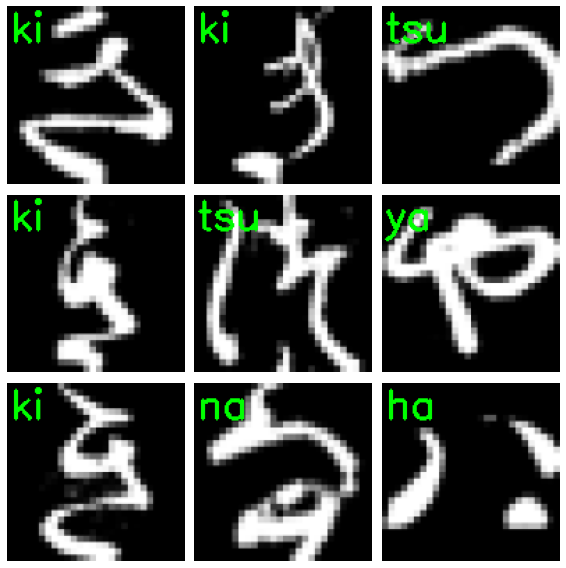

In [21]:
%matplotlib inline
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Directory path where the images are stored
directory = "your_path"

# Getting the list of image file names in the directory
image_files = os.listdir(directory)

# Calculating the grid size based on the number of images
num_images = len(image_files)
grid_size = int(np.ceil(np.sqrt(num_images)))

# Creating the grid and display the images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
for i, image_file in enumerate(image_files):
    ax = axes[i // grid_size, i % grid_size]  # Get the corresponding axis

    # Reading the image using PIL
    image_path = os.path.join(directory, image_file)
    image = Image.open(image_path)

    ax.imshow(image)  # Display the image
    ax.axis('off')  # Turn off the axis labels

# Adjusting spacing and layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()

# Showing the grid of images
plt.show()

As we can see, our CNN is able to recognize Hiragana characters with a high accuracy, and this was also seen in the numerical performance metrics.